In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from tqdm import tqdm
from typing import Tuple
import pyro
from pyro.infer import MCMC, NUTS, HMC
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from easydict import EasyDict as edict
import jax
import ot
from collections import defaultdict
from functools import partial

from iterative_sir.sampling_utils.sir_ais_sampling import sir_correlated_dynamics
from iterative_sir.sampling_utils.adaptive_mc import adaptive_sir_correlated_dynamics, ex2_mcmc_mala, FlowMCMC, Ex2MCMC
from iterative_sir.sampling_utils.adaptive_sir_loss import *
from iterative_sir.sampling_utils.ebm_sampling import mala_dynamics
from iterative_sir.sampling_utils.flows import RNVP
from iterative_sir.sampling_utils.distributions import (Distribution,  
                           IndependentNormal,
                           init_independent_normal, 
                           Funnel,
                          Banana, HalfBanana, Cauchy)

from iterative_sir.sampling_utils.total_variation import average_total_variation
from iterative_sir.sampling_utils.metrics import ESS, acl_spectrum

In [4]:
import seaborn as sns
sns.set_theme(style="ticks", palette="deep")

In [5]:
from pathlib import Path
figpath = Path('../figs')

In [6]:
device = torch.device('cpu')

In [7]:
def instantiate_banana_dists(dim : int) -> Tuple[Distribution, Distribution]:
    target_args = edict()
    target_args.device = device
    target_args.dim = dim
    target_args.Q = .2
    true_target = Banana(**target_args)

    #loc_proposal = 2.+torch.zeros(n_dim).to(device)
    loc_proposal = torch.zeros(dim).to(device)
    scale_proposal = 3*torch.ones(dim).to(device)
    proposal_args = edict()
    proposal_args.device = device
    proposal_args.loc = loc_proposal
    proposal_args.scale = scale_proposal
    proposal = IndependentNormal(**proposal_args)

    return true_target, proposal

def instantiate_half_banana_dists(dim : int) -> Tuple[Distribution, Distribution]:
    target_args = edict()
    target_args.device = device
    target_args.dim = dim
    target_args.Q = .2
    true_target = HalfBanana(**target_args)

    #loc_proposal = 2.+torch.zeros(n_dim).to(device)
    loc_proposal = torch.zeros(dim).to(device)
    scale_proposal = 3*torch.ones(dim).to(device)
    proposal_args = edict()
    proposal_args.device = device
    proposal_args.loc = loc_proposal
    proposal_args.scale = scale_proposal
    proposal = IndependentNormal(**proposal_args)

    return true_target, proposal

def instantiate_funnel_dists(dim: int) -> Tuple[Distribution, Distribution]:
    target_args = edict()
    target_args.device = device
    target_args.dim = dim
    true_target = Funnel(**target_args)

    loc_proposal = torch.zeros(dim).to(device)
    scale_proposal = torch.ones(dim).to(device)
    proposal_args = edict()
    proposal_args.device = device
    proposal_args.loc = loc_proposal
    proposal_args.scale = scale_proposal
    proposal = IndependentNormal(**proposal_args)

    return true_target, proposal


In [8]:
def plot_hist(samples, title = 'Histogram', bins=200, 
              gamma=0.5, dims=[0, 1], ax_lims = [(-2,9), (-2,4)],
              save_path = 'pics/histogram_test.pdf', density = True):
    plt.close()
    plt.figure(figsize=(5, 5), dpi=300)
    plt.hist2d(samples[:,dims[0]], samples[:,dims[1]],bins=bins, density=density, range=[ax_lims[0], ax_lims[1]],norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.axis('off')
    plt.xlim((ax_lims[0][0], ax_lims[0][1]))
    plt.ylim((ax_lims[1][0], ax_lims[1][1]))
    plt.savefig(save_path, bbox_inches='tight')
    plt.show() 

from scipy.stats import gaussian_kde

def plot_kde(samples, dims=[0, 1], ax_lims=[(-2,9), (-2,4)], max_pts=200, fig=None, cmap=None, color=None):
    if fig is None: 
      plt.close()
      fig = plt.figure(figsize=(5, 5)) #, dpi=300)

    X, Y = np.mgrid[ax_lims[0][0]:ax_lims[0][1]:100j, ax_lims[1][0]:ax_lims[1][1]:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    kde_inp = np.stack([samples[:, dims[0]], samples[:, dims[1]]], 1).T
    kernel = gaussian_kde(kde_inp)
    Z = np.reshape(kernel(positions).T, X.shape)

    if cmap is None:
        cmap = plt.cm.gist_earth_r

    if color is None:
        color = 'black'
        
    plt.imshow(np.rot90(Z), cmap=cmap,
          extent=[ax_lims[0][0], ax_lims[0][1], ax_lims[1][0], ax_lims[1][1]], alpha=0.5)

    plt.plot(samples[-max_pts:, dims[0]], samples[-max_pts:, dims[1]], 'k.', markersize=2, c=color)
    plt.xlim([ax_lims[0][0], ax_lims[0][1]])
    plt.ylim([ax_lims[1][0], ax_lims[1][1]])
    plt.axis('square')

    return fig

def compute_metrics(xs_true, xs_pred, name=None, n_samples=1000, scale=1.):
    metrics = dict()
    key = jax.random.PRNGKey(0)
    n_steps = 10
    n_samples = 100
    tracker = average_total_variation(key, xs_true, xs_pred, n_steps=n_steps, n_samples=n_samples)

    metrics['tv_mean'] = tracker.mean()
    metrics['tv_conf_sigma'] = tracker.std_of_mean()

    mean = tracker.mean()
    std = tracker.std()

    ess = ESS(acl_spectrum((xs_pred - xs_pred.mean(0)[None, ...]))).mean()
    metrics['ess'] = ess

    M = ot.dist(xs_true / scale, xs_pred / scale)
    emd = ot.lp.emd2([], [], M)

    metrics['emd'] = emd

    if name is not None:
        print(f'===={name}====')
    print(f'TV distance. Mean: {mean:.3f}, Std: {std:.3f}. \nESS: {ess:.3f} \nEMD: {emd:.3f}')

    return metrics


In [9]:
from matplotlib.colors import LinearSegmentedColormap

def get_custom_cmap(cmap, name):
    ncolors = 256
    color_array = cmap(range(ncolors))

    # change alpha values
    color_array[:,-1] = np.linspace(0.0, 1.0, ncolors)

    # create a colormap object
    map_object = LinearSegmentedColormap.from_list(name=name,colors=color_array)

    # register this new colormap with matplotlib
    plt.register_cmap(cmap=map_object)
    

get_custom_cmap(plt.cm.Blues, 'blue_alpha')
get_custom_cmap(plt.cm.Reds, 'red_alpha')

In [10]:
def sample_nuts(target, proposal, num_samples=1000):
    true_target_energy = lambda z: - target(z)

    def energy(z):
        z = z['points']
        return true_target_energy(z).sum()


    #kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
    kernel_true = NUTS(potential_fn=energy, full_mass = False)
    init_samples = proposal.sample((1,))
    dim = init_samples.shape[-1]

    init_params = {'points': init_samples}
    mcmc_true = MCMC(kernel=kernel_true, num_samples = num_samples, initial_params=init_params)
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"].squeeze()
    samples_true = np.array(q_true.view(-1, dim))

    return samples_true

In [11]:
def plot_metrics(metrics, ndims, savepath=None, scale=1.):
    axs_names = ['Sliced TV', 'ESS', 'Euclidean EMD (on scaled data)']
    ncols = len(axs_names)
    fig, axs = plt.subplots(ncols=ncols, figsize=(5*ncols + ncols, 5))
    
    for name, res in metrics.items():
        for k, v in res.items():
            res[k] = np.array(v)

        arr = res['tv_mean']
        axs[0].plot(ndims, arr, label=name, marker='o')

        axs[0].fill_between(ndims, res['tv_mean'] - 1.96 * res['tv_conf_sigma'], res['tv_mean'] + 1.96 * res['tv_conf_sigma'], alpha=0.2)

        arr = res['ess']
        axs[1].plot(ndims, arr, label=name, marker='o')

        arr = res['emd']
        axs[2].plot(ndims, arr, label=name, marker='o')


    for ax, name in zip(axs, axs_names):
        ax.grid()
        ax.set_title(name)
        ax.set_xlabel('dim')
        ax.legend()

    fig.tight_layout()

    if savepath is not None:
        plt.savefig(savepath)
    #plt.show()

# Begining

In [12]:
lr = 1e-2

# Half Banana

In [18]:
if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()

ndims = [6] #, 10, 20, 36, 50]

N = 10
n_steps = 1000

batch_size = 100
loss = "mix_kl"
optimizer = 'adam'

grad_step = 1e-1

method_args = edict()
method_args.n_steps = 1
method_args.N = N
method_args.mala_steps = 50
method_args.corr_coef = 0.9
method_args.bernoulli_prob_corr = 0.5
method_args.grad_step = grad_step
method_args.noise_scale = (2 * grad_step) ** .5
method_args.adapt_stepsize = True
method_args.verbose = False
mcmc_call = partial(ex2_mcmc_mala, **method_args)

# !
method_metric_dict = defaultdict(lambda : defaultdict(list))

for dim in ndims:
    print(f'=== Dimension: {dim} ===')
    target, proposal = instantiate_half_banana_dists(dim)

    print('Nuts sampling')
    #samples_true = sample_nuts(target, proposal, num_samples=n_steps)

    flow = RNVP(num_flows=4, dim=dim)
    ex2mcmc = Ex2MCMC(N)
    mcmc_call = partial(ex2mcmc, **method_args)
    flow_mcmc = FlowMCMC(target, proposal, flow, mcmc_call, batch_size=batch_size, lr=lr)
    _ = flow_mcmc.train(n_steps=100)

    z_0 = proposal.sample((1,))

    mala_steps = 50
    corr_coef = 0.9
    bernoulli_prob_corr = 0.3 #0.3 #0.5
    
    zl, accept, _ = ex2mcmc(z_0, target,  proposal, n_steps, N=N, grad_step=grad_step, noise_scale=(2*grad_step)**.5, 
                            mala_steps=mala_steps, corr_coef=corr_coef, bernoulli_prob_corr=bernoulli_prob_corr, flow=flow, 
                            adapt_stepsize=True, verbose=True)
    zl = zl[-n_steps:]
    flow_samples = np.array([_.detach().numpy() for _ in zl]).reshape(-1, dim)

    # ex2mcmc = Ex2MCMC(N)
    # zl, accept, _ = ex2mcmc(z_0, target,  proposal, n_steps, N=N, grad_step=grad_step, noise_scale=(2*grad_step)**.5, 
    #                         mala_steps=mala_steps, corr_coef=corr_coef, bernoulli_prob_corr=bernoulli_prob_corr, flow=None, 
    #                         adapt_stepsize=True, verbose=True)
    # zl = zl[-n_steps:]
    # wo_flow_samples = np.array([_.detach().numpy() for _ in zl]).reshape(-1, dim)


    # zl, _ = mala_dynamics(z_0, target, proposal, n_steps * mala_steps, grad_step=1e-2, eps_scale=(2e-2)**.5, adapt_stepsize=True)
    # zl = zl[-n_steps:]
    # mala_samples = np.array([_.detach().numpy() for _ in zl]).reshape(-1, dim)

    # for samples, name in zip([flow_samples, wo_flow_samples, mala_samples], [r'FlEx$^2$MCMC-MALA', 'Ex$^2$MCMC-MALA', 'MALA']):
    #     metrics = compute_metrics(samples_true, samples, name, scale=3.)
    #     for k, v in metrics.items():
    #         method_metric_dict[name][k] = list(method_metric_dict[name][k])
    #         method_metric_dict[name][k].append(v)


  1%|          | 1/100 [00:00<00:19,  5.14it/s]

=== Dimension: 6 ===
Nuts sampling


100%|██████████| 1000/1000 [00:57<00:00, 17.25it/s]


In [19]:
metrics = compute_metrics(samples_true, flow_samples, '')

TV distance. Mean: 0.043, Std: 0.010. 
ESS: 0.147 
EMD: 0.764


In [18]:
import pickle

method_metric_dict = dict(method_metric_dict)
pickle.dump(method_metric_dict, Path('../dump/half_banana_metrics.pkl').open('wb'))
method_metric_dict = pickle.load(Path('../dump/half_banana_metrics.pkl').open('rb'))

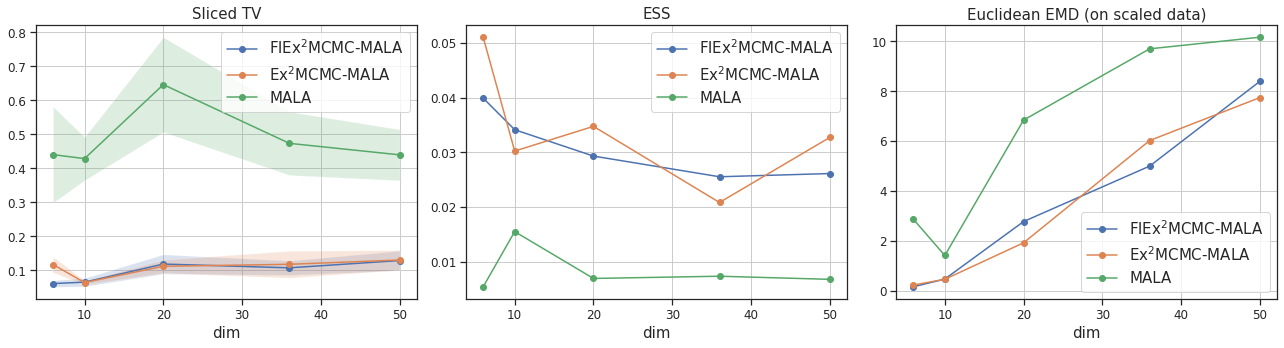

In [19]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12 #8
MEDIUM_SIZE = 15 #10
BIGGER_SIZE = 15 #12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plot_metrics(method_metric_dict, ndims, savepath=Path(figpath, 'half_banana_metrics.pdf'))

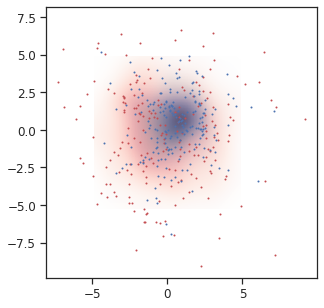

In [20]:
z_0 = proposal.sample((1000,))
z_1, _ = flow(z_0)

dim1 = 1 #16
dim2 = 2 #17

prior = z_0.detach().cpu().numpy()
poster = z_1.detach().cpu().numpy()

up_quantile = 0.95
low_quantile = 0.05

ax_lims1 = [(np.quantile(prior[:, dim1], low_quantile), np.quantile(prior[:, dim1], up_quantile)), (np.quantile(prior[:, dim2], low_quantile), np.quantile(prior[:, dim2], up_quantile))]
ax_lims2 = [(np.quantile(poster[:, dim1], low_quantile), np.quantile(poster[:, dim1], up_quantile)), (np.quantile(poster[:, dim2], low_quantile), np.quantile(poster[:, dim2], up_quantile))]

ax_lims = [(min(ax_lims1[0][0], ax_lims2[0][0]), max(ax_lims1[0][1], ax_lims2[0][1])), (min(ax_lims1[1][0], ax_lims2[1][0]), max(ax_lims1[1][1], ax_lims2[1][1]))]
fig = plot_kde(prior, [dim1, dim2], ax_lims=ax_lims, cmap = 'red_alpha', color='r')

plot_kde(poster, [dim1, dim2], ax_lims=ax_lims, fig=fig, cmap = 'blue_alpha', color='b')

plt.show()

In [21]:
# plot_hist(samples, title = '', gamma = 0.2, save_path = 'Ex2MCMC_banana_w_flows.pdf')


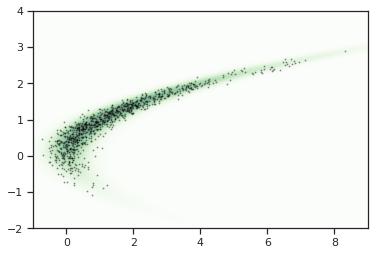

In [16]:
fig, xlim, ylim = target.plot_2d()

plt.scatter(flow_samples[:, 0], flow_samples[:, 1], alpha=0.3, s=1, color='black')
# plt.axis('equal')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()

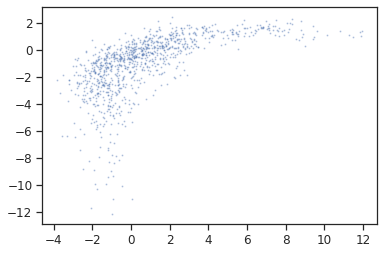

In [23]:
out, _ = flow.inverse(torch.FloatTensor(flow_samples))

plt.scatter(out[:, 0].detach(), out[:, 1].detach(), alpha=0.3, s=1)

In [24]:
# out, _ = flow.inverse(torch.cat(zl, 0))

# plt.scatter(out[:, 0].detach(), out[:, 1].detach(), alpha=0.3)

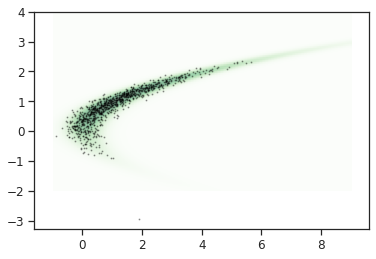

In [25]:
fig, xlim, ylim = target.plot_2d()

plt.scatter(wo_flow_samples[:, 0], wo_flow_samples[:, 1], alpha=0.3, s=1, color='black')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()

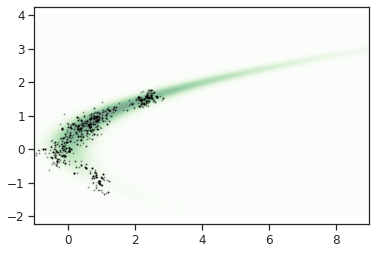

In [26]:
fig, xlim, ylim = target.plot_2d()

plt.scatter(mala_samples[:, 0], mala_samples[:, 1], alpha=0.3, s=1, color='black')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()

In [27]:
ess = ESS(acl_spectrum((samples_true - samples_true.mean(0)[None, ...]))).mean()

print(f'ESS: {ess:.3f}')

ESS: 0.380


In [28]:
# plot_hist(flow_samples, title = '', gamma = 0.2, save_path = Path(figpath, 'Ex2MCMC_banana_w_flows.pdf'))
# plot_hist(wo_flow_samples, title = '', gamma = 0.2, save_path = Path(figpath, 'Ex2MCMC_banana_wo_flows.pdf'))

# Full Banana

In [29]:
if hasattr(tqdm, '_instances'):
    tqdm._instances.clear()

ndims = [6] #, 10, 20, 36, 50]

N = 10
n_steps = 1000

batch_size = 100
loss = "mix_kl"
optimizer = 'adam'

grad_step = 1e-1

method_args = edict()
method_args.n_steps = 1
method_args.N = N
method_args.mala_steps = 100
method_args.corr_coef = 0.9
method_args.bernoulli_prob_corr = 0.5
method_args.grad_step = grad_step
method_args.noise_scale = (2 * grad_step) ** .5
method_args.adapt_stepsize = True
mcmc_call = partial(ex2_mcmc_mala, **method_args)

method_metric_dict = defaultdict(lambda : defaultdict(list))

for dim in ndims:
    print(f'=== Dimension: {dim} ===')
    target, proposal = instantiate_banana_dists(dim)

    print('Nuts sampling')
    samples_true = sample_nuts(target, proposal, num_samples=n_steps)

    flow = RNVP(num_flows=4, dim=dim)
    ex2mcmc = Ex2MCMC(N)
    mcmc_call = partial(ex2mcmc, **method_args)
    flow_mcmc = FlowMCMC(target, proposal, flow, optimizer, loss, mcmc_call, batch_size=batch_size, lr=lr))
    _ = flow_mcmc.train(n_steps=100)

    z_0 = proposal.sample((1,))

    mala_steps = 50
    corr_coef = 0.9
    bernoulli_prob_corr = 0.3 #0.3 #0.5
    
    zl, accept, _ = ex2mcmc(z_0, target,  proposal, n_steps, N=N, grad_step=grad_step, noise_scale=(2*grad_step)**.5, 
                            mala_steps=mala_steps, corr_coef=corr_coef, bernoulli_prob_corr=bernoulli_prob_corr, flow=flow, 
                            adapt_stepsize=True, verbose=True)
    zl = zl[-n_steps:]
    flow_samples = np.array([_.detach().numpy() for _ in zl]).reshape(-1, dim)

    # ex2mcmc = Ex2MCMC(N)
    # zl, accept, _ = ex2mcmc(z_0, target,  proposal, n_steps, N=N, grad_step=grad_step, noise_scale=(2*grad_step)**.5, 
    #                         mala_steps=mala_steps, corr_coef=corr_coef, bernoulli_prob_corr=bernoulli_prob_corr, flow=None, 
    #                         adapt_stepsize=True, verbose=True)
    # zl = zl[-n_steps:]
    # wo_flow_samples = np.array([_.detach().numpy() for _ in zl]).reshape(-1, dim)


    # zl, _ = mala_dynamics(z_0, target, proposal, n_steps * mala_steps, grad_step=1e-2, eps_scale=(2e-2)**.5, adapt_stepsize=True)
    # zl = zl[-n_steps:]
    # mala_samples = np.array([_.detach().numpy() for _ in zl]).reshape(-1, dim)

    # for samples, name in zip([flow_samples, wo_flow_samples, mala_samples], [r'FlEx$^2$MCMC-MALA', 'Ex$^2$MCMC-MALA', 'MALA']):
    #     metrics = compute_metrics(samples_true, samples, name, scale=3.)
    #     for k, v in metrics.items():
    #         method_metric_dict[name][k] = list(method_metric_dict[name][k])
    #         method_metric_dict[name][k].append(v)


Warmup:   0%|          | 0/2000 [00:00, ?it/s]

=== Dimension: 6 ===
Nuts sampling


100%|██████████| 1000/1000 [00:51<00:00, 19.56it/s]
                                               

====FlEx$^2$MCMC-MALA====
TV distance. Mean: 0.047, Std: 0.021. 
ESS: 0.209 
EMD: 0.055


====Ex$^2$MCMC-MALA====
TV distance. Mean: 0.047, Std: 0.017. 
ESS: 0.191 
EMD: 0.048


Warmup:   0%|          | 10/2000 [00:00, 99.07it/s, step size=1.14e-01, acc. prob=0.746]

====MALA====
TV distance. Mean: 0.218, Std: 0.133. 
ESS: 0.012 
EMD: 0.249
=== Dimension: 10 ===
Nuts sampling


100%|██████████| 1000/1000 [00:55<00:00, 18.17it/s]
                                               

====FlEx$^2$MCMC-MALA====
TV distance. Mean: 0.050, Std: 0.023. 
ESS: 0.166 
EMD: 0.201


====Ex$^2$MCMC-MALA====
TV distance. Mean: 0.060, Std: 0.014. 
ESS: 0.174 
EMD: 0.198


Warmup:   1%|          | 17/2000 [00:00, 112.61it/s, step size=3.77e-02, acc. prob=0.773]

====MALA====
TV distance. Mean: 0.208, Std: 0.091. 
ESS: 0.016 
EMD: 0.449
=== Dimension: 20 ===
Nuts sampling


100%|██████████| 1000/1000 [01:04<00:00, 15.39it/s]
                                              

====FlEx$^2$MCMC-MALA====
TV distance. Mean: 0.046, Std: 0.010. 
ESS: 0.134 
EMD: 0.863


====Ex$^2$MCMC-MALA====
TV distance. Mean: 0.053, Std: 0.019. 
ESS: 0.133 
EMD: 0.880


Warmup:   0%|          | 7/2000 [00:00, 66.67it/s, step size=1.31e-01, acc. prob=0.760]

====MALA====
TV distance. Mean: 0.252, Std: 0.116. 
ESS: 0.010 
EMD: 1.529
=== Dimension: 36 ===
Nuts sampling


100%|██████████| 1000/1000 [00:57<00:00, 17.26it/s]
                                              

====FlEx$^2$MCMC-MALA====
TV distance. Mean: 0.067, Std: 0.022. 
ESS: 0.100 
EMD: 2.343


====Ex$^2$MCMC-MALA====
TV distance. Mean: 0.057, Std: 0.018. 
ESS: 0.107 
EMD: 2.376


Warmup:   0%|          | 10/2000 [00:00, 90.44it/s, step size=2.20e-02, acc. prob=0.716]

====MALA====
TV distance. Mean: 0.232, Std: 0.059. 
ESS: 0.009 
EMD: 3.328
=== Dimension: 50 ===
Nuts sampling


100%|██████████| 1000/1000 [01:00<00:00, 16.52it/s]
                                              

====FlEx$^2$MCMC-MALA====
TV distance. Mean: 0.062, Std: 0.021. 
ESS: 0.094 
EMD: 3.765


====Ex$^2$MCMC-MALA====
TV distance. Mean: 0.067, Std: 0.029. 
ESS: 0.097 
EMD: 3.843


====MALA====
TV distance. Mean: 0.388, Std: 0.120. 
ESS: 0.009 
EMD: 5.571


In [30]:
import pickle

method_metric_dict = dict(method_metric_dict)
pickle.dump(method_metric_dict, Path('../dump/banana_metrics.pkl').open('wb'))
method_metric_dict = pickle.load(Path('../dump/banana_metrics.pkl').open('rb'))

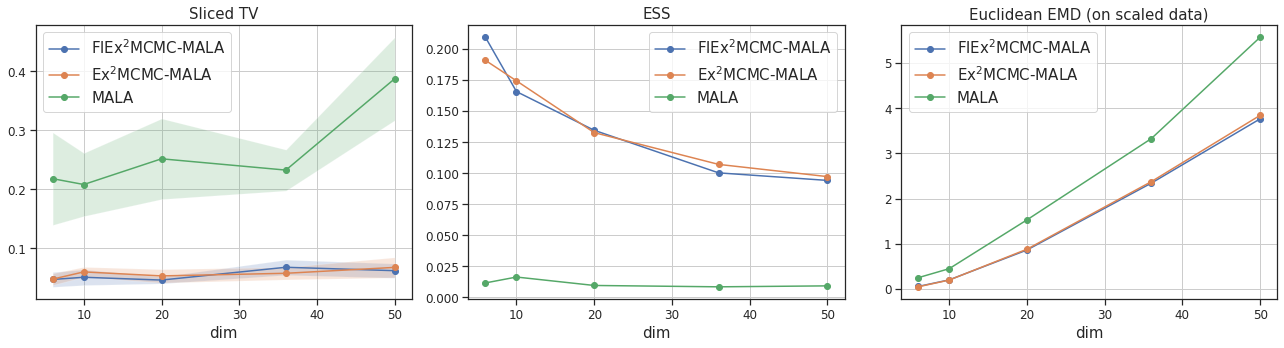

In [31]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12 #8
MEDIUM_SIZE = 15 #10
BIGGER_SIZE = 15 #12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plot_metrics(method_metric_dict, ndims, savepath=Path(figpath, 'banana_metrics.pdf'))

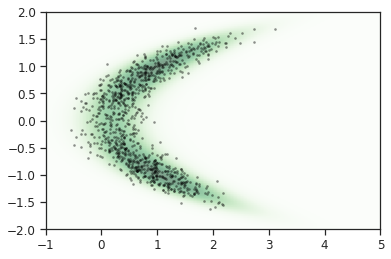

In [32]:
fig, xlim, ylim = target.plot_2d()

plt.scatter(flow_samples[:, 0], flow_samples[:, 1], alpha=0.3, s=1, color='black')
# plt.axis('equal')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()

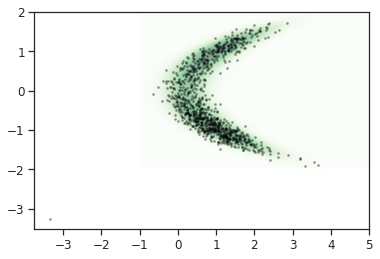

In [33]:
fig, xlim, ylim = target.plot_2d()

plt.scatter(wo_flow_samples[:, 0], wo_flow_samples[:, 1], alpha=0.3, s=1, color='black')
# plt.axis('equal')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()

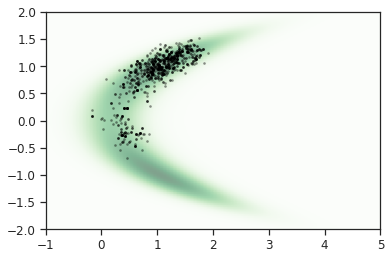

In [34]:
fig, xlim, ylim = target.plot_2d()

plt.scatter(mala_samples[:, 0], mala_samples[:, 1], alpha=0.3, s=1, color='black')
# plt.axis('equal')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()

# Funnel distribution

In [35]:
ndims = [5, 10, 15, 20] #, 25]

N = 10
n_steps = 1000

batch_size = 500
loss = "mix_kl"
optimizer = 'adam'

grad_step = 1e-1

method_args = edict()
method_args.n_steps = 1
method_args.N = N
method_args.mala_steps = 100
method_args.corr_coef = 0.9
method_args.bernoulli_prob_corr = 0.3 #0.5
method_args.grad_step = grad_step
method_args.noise_scale = (2 * grad_step) ** .5
method_args.adapt_stepsize = True

method_metric_dict = defaultdict(lambda : defaultdict(list))

for dim in ndims:
    print(f'=== Dimension: {dim} ===')
    target, proposal = instantiate_funnel_dists(dim)

    print('Nuts sampling')
    samples_true = sample_nuts(target, proposal, num_samples=n_steps)

    flow = RNVP(num_flows=4, dim=dim)
    ex2mcmc = Ex2MCMC(N)
    mcmc_call = partial(ex2mcmc, **method_args)
    flow_mcmc = FlowMCMC(target, proposal, flow, optimizer, loss, mcmc_call, batch_size=batch_size, lr=lr))
    _ = flow_mcmc.train(n_steps=100)

    z_0 = proposal.sample((1,))

    mala_steps = 50
    corr_coef = 0.9
    bernoulli_prob_corr = 0.3 #0.3 #0.5

    zl, accept, _ = ex2mcmc(z_0, target,  proposal, n_steps, N=N, grad_step=grad_step, noise_scale=(2*grad_step)**.5, 
                            mala_steps=mala_steps, corr_coef=corr_coef, bernoulli_prob_corr=bernoulli_prob_corr, flow=flow, 
                            adapt_stepsize=True, verbose=True)
    zl = zl[-n_steps:]
    flow_samples = np.array([_.detach().numpy() for _ in zl]).reshape(-1, dim)

    ex2mcmc = Ex2MCMC(N)
    zl, accept, _ = ex2mcmc(z_0, target,  proposal, n_steps, N=N, grad_step=grad_step, noise_scale=(2*grad_step)**.5, 
                            mala_steps=mala_steps, corr_coef=corr_coef, bernoulli_prob_corr=bernoulli_prob_corr, flow=None, 
                            adapt_stepsize=True, verbose=True)
    zl = zl[-n_steps:]
    wo_flow_samples = np.array([_.detach().numpy() for _ in zl]).reshape(-1, dim)


    zl, _ = mala_dynamics(z_0, target, proposal, n_steps * mala_steps, grad_step=1e-2, eps_scale=(2e-2)**.5, adapt_stepsize=True)
    zl = zl[-n_steps:]
    mala_samples = np.array([_.detach().numpy() for _ in zl]).reshape(-1, dim)

    for samples, name in zip([flow_samples, wo_flow_samples, mala_samples], [r'FlEx$^2$MCMC-MALA', 'Ex$^2$MCMC-MALA', 'MALA']):
        scale = samples_true.max()
        metrics = compute_metrics(samples_true, samples, name, scale=10.)
        for k, v in metrics.items():
            method_metric_dict[name][k] = list(method_metric_dict[name][k])
            method_metric_dict[name][k].append(v)


Warmup:   0%|          | 5/2000 [00:00, 45.52it/s, step size=2.44e-01, acc. prob=0.598]

=== Dimension: 5 ===
Nuts sampling


100%|██████████| 1000/1000 [00:59<00:00, 16.75it/s]
                                              

====FlEx$^2$MCMC-MALA====
TV distance. Mean: 0.049, Std: 0.013. 
ESS: 0.148 
EMD: 0.225


====Ex$^2$MCMC-MALA====
TV distance. Mean: 0.044, Std: 0.010. 
ESS: 0.163 
EMD: 0.159


Warmup:   0%|          | 3/2000 [00:00, 23.89it/s, step size=1.92e-01, acc. prob=0.392]

====MALA====
TV distance. Mean: 0.138, Std: 0.036. 
ESS: 0.022 
EMD: 0.301
=== Dimension: 10 ===
Nuts sampling


100%|██████████| 1000/1000 [00:54<00:00, 18.45it/s]
                                              

====FlEx$^2$MCMC-MALA====
TV distance. Mean: 0.089, Std: 0.021. 
ESS: 0.031 
EMD: 11.167


====Ex$^2$MCMC-MALA====
TV distance. Mean: 0.109, Std: 0.034. 
ESS: 0.020 
EMD: 13.569


Warmup:   0%|          | 5/2000 [00:00, 41.34it/s, step size=8.63e-01, acc. prob=0.682]

====MALA====
TV distance. Mean: 0.424, Std: 0.121. 
ESS: 0.021 
EMD: 22.066
=== Dimension: 15 ===
Nuts sampling


 50%|█████     | 5/10 [00:00<00:00, 44.54it/s]

====FlEx$^2$MCMC-MALA====
TV distance. Mean: 0.313, Std: 0.112. 
ESS: 0.011 
EMD: 232.179


====Ex$^2$MCMC-MALA====
TV distance. Mean: 0.349, Std: 0.055. 
ESS: 0.010 
EMD: 235.173


Warmup:   0%|          | 0/2000 [00:00, ?it/s]

====MALA====
TV distance. Mean: 0.835, Std: 0.065. 
ESS: 0.015 
EMD: 578.731
=== Dimension: 20 ===
Nuts sampling


100%|██████████| 1000/1000 [01:24<00:00, 11.79it/s]
                                              

====FlEx$^2$MCMC-MALA====
TV distance. Mean: 0.639, Std: 0.055. 
ESS: 0.007 
EMD: 5037.112


====Ex$^2$MCMC-MALA====
TV distance. Mean: 0.625, Std: 0.035. 
ESS: 0.007 
EMD: 5071.184


====MALA====
TV distance. Mean: 0.951, Std: 0.259. 
ESS: 0.019 
EMD: 6504.364


In [36]:
import pickle

method_metric_dict = dict(method_metric_dict)
pickle.dump(method_metric_dict, Path('../dump/funnel_metrics.pkl').open('wb'))
method_metric_dict = pickle.load(Path('../dump/funnel_metrics.pkl').open('rb'))

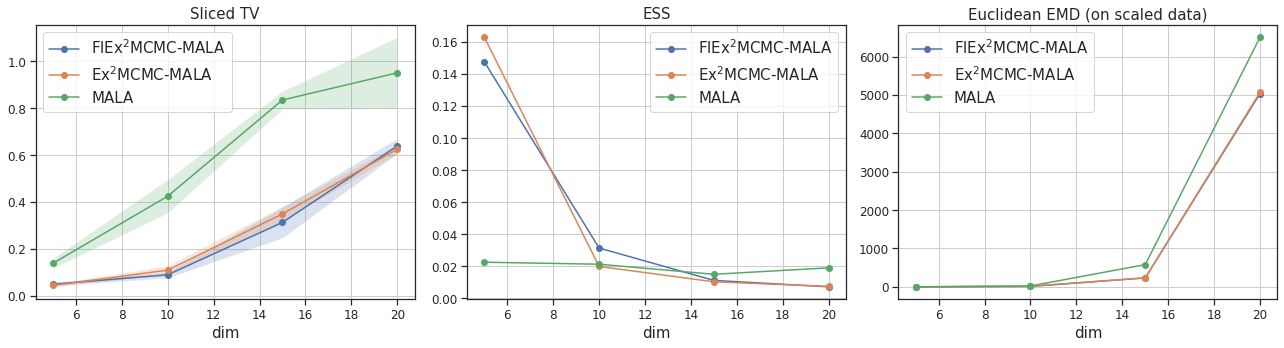

In [37]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12 #8
MEDIUM_SIZE = 15 #10
BIGGER_SIZE = 15 #12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plot_metrics(method_metric_dict, ndims, savepath=Path(figpath, 'funnel_metrics.pdf'))

In [38]:
# plot_hist(samples, title = '', dims=[0, 1], ax_lims=ax_lims, gamma = 0.2, save_path = 'Ex2MCMC_funnel_w_flows.pdf')

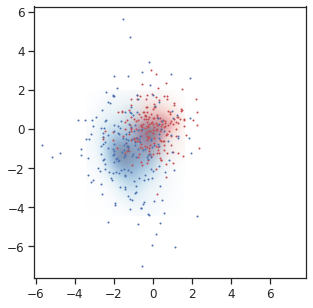

In [39]:
z_0 = proposal.sample((1000,))
z_1, _ = flow(z_0)

dim1 = 1 #16
dim2 = 2 #17

prior = z_0.detach().cpu().numpy()
poster = z_1.detach().cpu().numpy()

up_quantile = 0.95
low_quantile = 0.05

ax_lims1 = [(np.quantile(prior[:, dim1], low_quantile), np.quantile(prior[:, dim1], up_quantile)), (np.quantile(prior[:, dim2], low_quantile), np.quantile(prior[:, dim2], up_quantile))]
ax_lims2 = [(np.quantile(poster[:, dim1], low_quantile), np.quantile(poster[:, dim1], up_quantile)), (np.quantile(poster[:, dim2], low_quantile), np.quantile(poster[:, dim2], up_quantile))]

ax_lims = [(min(ax_lims1[0][0], ax_lims2[0][0]), max(ax_lims1[0][1], ax_lims2[0][1])), (min(ax_lims1[1][0], ax_lims2[1][0]), max(ax_lims1[1][1], ax_lims2[1][1]))]
fig = plot_kde(prior, [dim1, dim2], ax_lims=ax_lims, cmap = 'red_alpha', color='r')

plot_kde(poster, [dim1, dim2], ax_lims=ax_lims, fig=fig, cmap = 'blue_alpha', color='b')

plt.show()

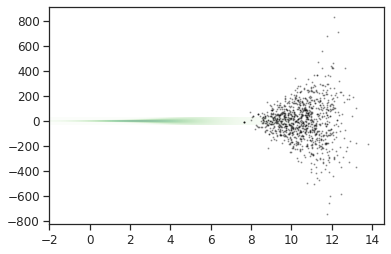

In [40]:
fig, xlim, ylim = target.plot_2d()

plt.scatter(samples_true[:, 0], samples_true[:, 1], alpha=0.3, s=1, color='black')
#plt.axis('equal')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()

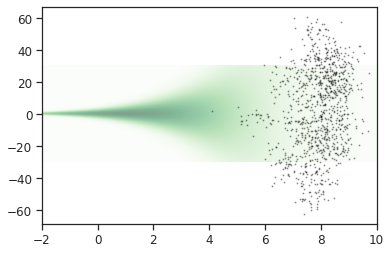

In [41]:
fig, xlim, ylim = target.plot_2d()

plt.scatter(flow_samples[:, 0], flow_samples[:, 1], alpha=0.3, s=1, color='black')
#plt.axis('equal')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()

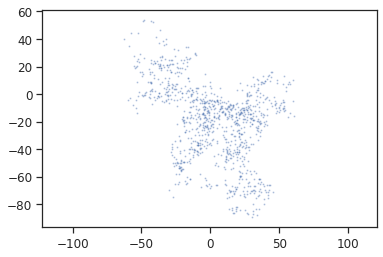

In [42]:
plt.scatter(flow_samples[:, 1], flow_samples[:, 2], alpha=0.3, s=1)
plt.axis('equal')
plt.show()

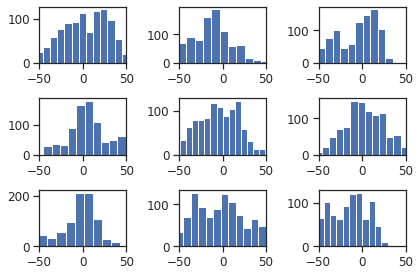

In [43]:
fig, axs = plt.subplots(ncols=3, nrows=3)
for i, ax in enumerate(axs.flatten()):
    ax.hist(flow_samples[:, i+1], bins=15)
    ax.set_xlim(-50, 50)
fig.tight_layout()
plt.show()

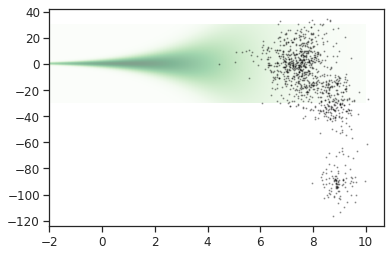

In [44]:
fig, xlim, ylim = target.plot_2d()

plt.scatter(wo_flow_samples[:, 0], wo_flow_samples[:, 1], alpha=0.3, s=1, color='black')
#plt.axis('equal')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.show()

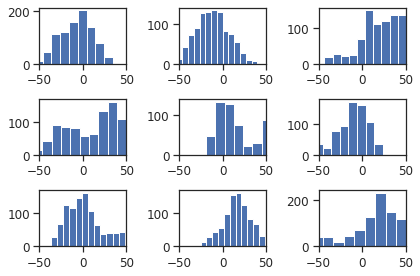

In [45]:
fig, axs = plt.subplots(ncols=3, nrows=3)
for i, ax in enumerate(axs.flatten()):
    ax.hist(wo_flow_samples[:, i+1], bins=15)
    ax.set_xlim(-50, 50)
fig.tight_layout()
plt.show()

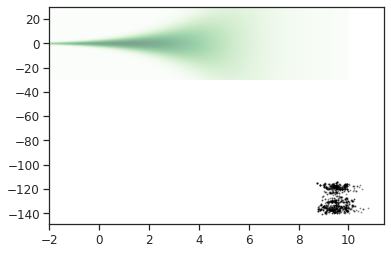

In [46]:
fig = target.plot_2d()

plt.scatter(mala_samples[:, 0], mala_samples[:, 1], alpha=0.3, s=1, color='black')
#plt.axis('equal')
plt.show()

In [47]:
ess = ESS(acl_spectrum((samples_true - samples_true.mean(0)[None, ...]))).mean()

print(f'ESS: {ess:.3f}')

ESS: 0.433


In [48]:
# plot_hist(flow_samples, title = '', gamma = 0.2, save_path = Path(figpath, 'Ex2MCMC_funnel_w_flows.pdf'))
# plot_hist(wo_flow_samples, title = '', gamma = 0.2, save_path = Path(figpath, 'Ex2MCMC_funnel_w_flows.pdf'))